# In this tutorial we'll see what to watch for during and after the network training

## Monitoring training health

First let's look at at the training history - we want to display the training set loss and vlidation set loss as a function of 'iteration' or the batch number seen by our model

In [1]:
import os,sys
currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from utils import plot_utils

In [3]:
%matplotlib inline

You will need to change the location of where these files are

In [4]:
loc="../model_state_dumps/20240425_141704/"

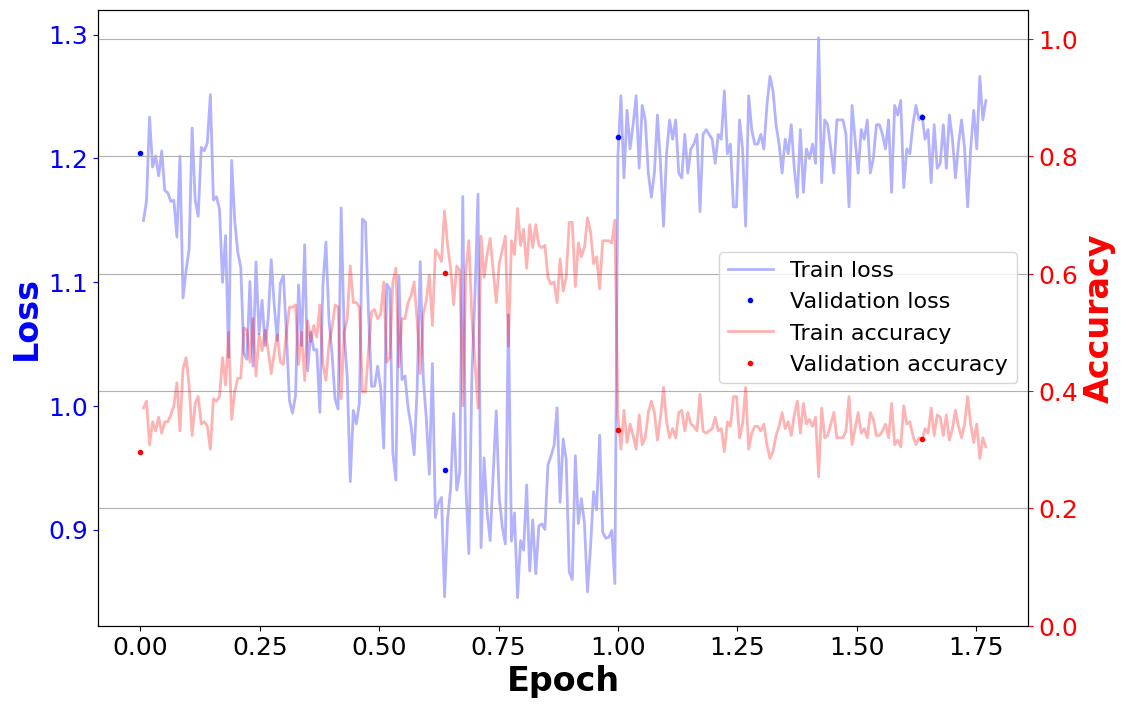

In [5]:
plot_utils.disp_learn_hist(loc)


Why so bumpy?
   - there is 'noise' associated with batch-to-batch variation BUT
   - The main effect is actually the real bumpiness in the loss landscape being traversed during learning
   
To learn anything we need to smooth out the plot - for instance by using moving average

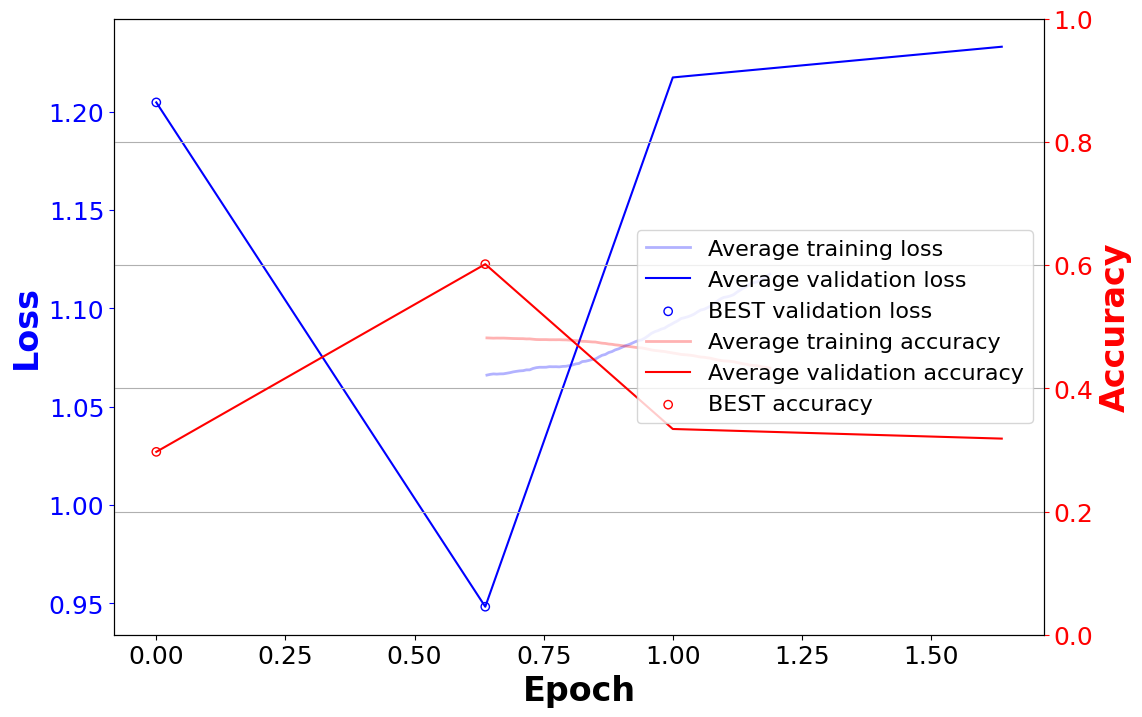

In [6]:
plot_utils.disp_learn_hist_smoothed(loc,window_train=200,window_val=1)

This actually looks pretty good - we get initially a very quick learning and then a plateau. Both training and validation loss is still decreasing slightly and tracking - which means we could probably kept on training

Let's run training on a small sample to illustrate overtraining

In [7]:
from models.simpleCNN import SimpleCNN
model_CNN=SimpleCNN(num_input_channels=38,num_classes=3)

In [8]:
from utils.data_handling import WCH5Dataset

In [9]:
import numpy as np
def rotate_chan(x):
    return np.transpose(x,(2,0,1))

In [10]:
dset=WCH5Dataset("/fast_scratch/TRISEP_data/NUPRISM.h5",reduced_dataset_size=10000,val_split=0.1,test_split=0.1,transform=rotate_chan)

Reduced size: 10000


In [11]:
class CONFIG:
    pass
config=CONFIG()
config.batch_size_test = 1024
config.batch_size_train = 32
config.batch_size_val = 512
config.lr=0.01
config.device = 'gpu'
config.gpu_list = [0]
config.dump_path = '../model_state_dumps'
config.num_workers_train=3
config.num_workers_val=2
config.num_workers_test=2

In [12]:
from utils.engine import Engine

In [13]:
engine=Engine(model_CNN,dset,config)

Requesting a GPU
CUDA is available
Creating a directory for run dump: ../model_state_dumps/20190823_091320/


In [14]:
engine.train(epochs=20,report_interval=10,valid_interval=10)

Epoch 0 Starting @ 2019-08-23 09:13:22
... Iteration 0 ... Epoch 0.00 ... Validation Loss 1.098 ... Validation Accuracy 0.338
Saved checkpoint as: ../model_state_dumps/20190823_091320/SimpleCNN.pth
best validation loss so far!: 1.0979317426681519
Saved checkpoint as: ../model_state_dumps/20190823_091320/SimpleCNNBEST.pth
... Iteration 1 ... Epoch 0.00 ... Loss 1.076 ... Accuracy 0.375
... Iteration 10 ... Epoch 0.04 ... Validation Loss 1.093 ... Validation Accuracy 0.326
Saved checkpoint as: ../model_state_dumps/20190823_091320/SimpleCNN.pth
best validation loss so far!: 1.092586636543274
Saved checkpoint as: ../model_state_dumps/20190823_091320/SimpleCNNBEST.pth
... Iteration 11 ... Epoch 0.04 ... Loss 1.101 ... Accuracy 0.281
starting over on the validation set
... Iteration 20 ... Epoch 0.08 ... Validation Loss 1.092 ... Validation Accuracy 0.311
Saved checkpoint as: ../model_state_dumps/20190823_091320/SimpleCNN.pth
best validation loss so far!: 1.0923552513122559
Saved checkpoint 

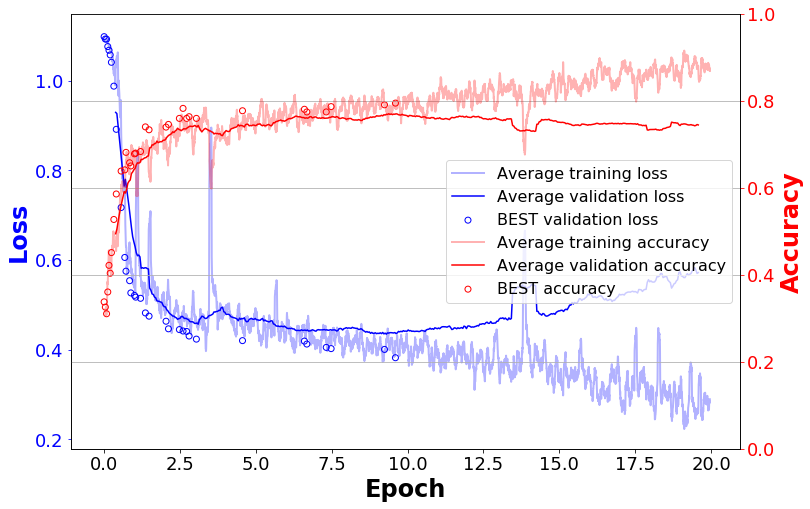

In [15]:
loc="../model_state_dumps/20190823_091320"
plot_utils.disp_learn_hist_smoothed(loc,window_train=20,window_val=20)

Now this clearly shows overtraining - validation loss starts to climb. Possibly other pathologies

## Evaluating model performance in classification task

Now let's go back to the full dataset and load the model trained last time on the full dataset

In [16]:
dset=WCH5Dataset("/fast_scratch/TRISEP_data/NUPRISM.h5",val_split=0.1,test_split=0.1,transform=rotate_chan)

In [17]:
!ls ../model_state_dumps/20190823_072324

config_log.txt	log_train.csv  log_val.csv  SimpleCNNBEST.pth  SimpleCNN.pth


In [18]:
engine=Engine(model_CNN,dset,config)

Requesting a GPU
CUDA is available
Creating a directory for run dump: ../model_state_dumps/20190823_092458/


In [19]:
engine.restore_state("../model_state_dumps/20190823_072324/SimpleCNNBEST.pth")

Restoring state from ../model_state_dumps/20190823_072324/SimpleCNNBEST.pth
Restoration complete.


In [20]:
engine.dirpath="../model_state_dumps/20190823_072324"

In [21]:
engine.validate()

val_iterations : 0
val_iterations : 1
val_iterations : 2
val_iterations : 3
val_iterations : 4
val_iterations : 5
val_iterations : 6
val_iterations : 7
val_iterations : 8
val_iterations : 9
val_iterations : 10
val_iterations : 11
val_iterations : 12
val_iterations : 13
val_iterations : 14
val_iterations : 15
val_iterations : 16
val_iterations : 17
val_iterations : 18
val_iterations : 19
val_iterations : 20
val_iterations : 21
val_iterations : 22
val_iterations : 23
val_iterations : 24
val_iterations : 25
val_iterations : 26
val_iterations : 27
val_iterations : 28
val_iterations : 29
val_iterations : 30
val_iterations : 31
val_iterations : 32
val_iterations : 33
val_iterations : 34
val_iterations : 35
val_iterations : 36
val_iterations : 37
val_iterations : 38
val_iterations : 39
val_iterations : 40
val_iterations : 41
val_iterations : 42
val_iterations : 43
val_iterations : 44
val_iterations : 45
val_iterations : 46
val_iterations : 47
val_iterations : 48
val_iterations : 49
val_iterat

### Examination of classifier output

Plot the classifier softmax output for various classes and outputs

In [22]:
labels_val=np.load(engine.dirpath + "labels.npy")
predictions_val=np.load(engine.dirpath + "predictions.npy")
softmax_out_val=np.load(engine.dirpath + "softmax.npy")

In [23]:
from matplotlib import pyplot as plt
def plot_resp(labels,softmax_out):
    fig1, ax1 = plt.subplots(figsize=(12,8),facecolor="w")
    ax1.tick_params(axis="both", labelsize=20)
    softmax_out_val_gamma_Pe=softmax_out_val[labels_val==0][:,1]
    softmax_out_val_e_Pe=softmax_out_val[labels_val==1][:,1]
    
    bins=np.linspace(0.0,1.0,51)
    values, bins, patches = ax1.hist(softmax_out_val_gamma_Pe, bins=bins, 
                                    label= 'gamma', color='blue', density=True,
                                    alpha=0.3)
    
    values, bins, patches = ax1.hist(softmax_out_val_e_Pe, bins=bins, 
                                    label= 'electron', color='red', density=True,
                                    alpha=0.3)
    ax1.legend(prop={'size': 16})
    ax1.set_xlabel('$P(e)$',fontweight='bold',fontsize=24,color='black')
    
    fig2, ax2 = plt.subplots(figsize=(12,8),facecolor="w")
    ax2.tick_params(axis="both", labelsize=20)
    softmax_out_val_e_Pmu=softmax_out_val[labels_val==1][:,2]
    softmax_out_val_mu_Pmu=softmax_out_val[labels_val==2][:,2]
    
    values, bins, patches = ax2.hist(softmax_out_val_mu_Pmu, bins=bins, 
                                    label= 'muon', color='green', density=True,
                                    alpha=0.3)
    
    values, bins, patches = ax2.hist(softmax_out_val_e_Pmu, bins=bins, 
                                    label= 'electron', color='red', density=True,
                                    alpha=0.3, log=True)
    ax2.legend(prop={'size': 16})
    ax2.set_xlabel('$P(\mu)$',fontweight='bold',fontsize=24,color='black')
    
    
    
    plt.show()

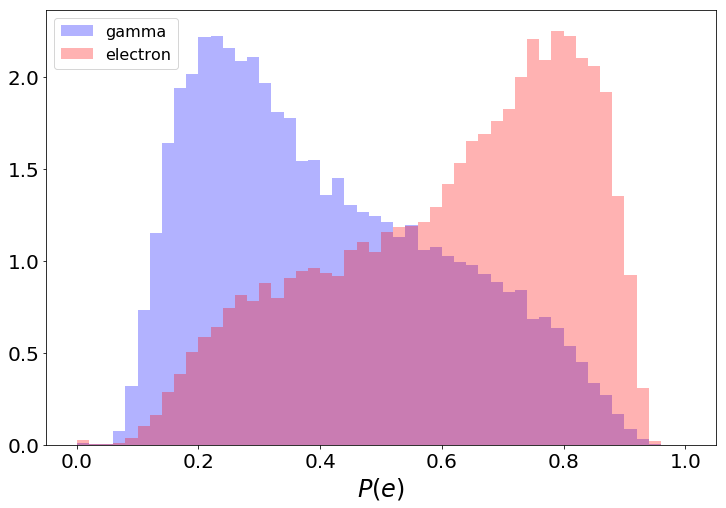

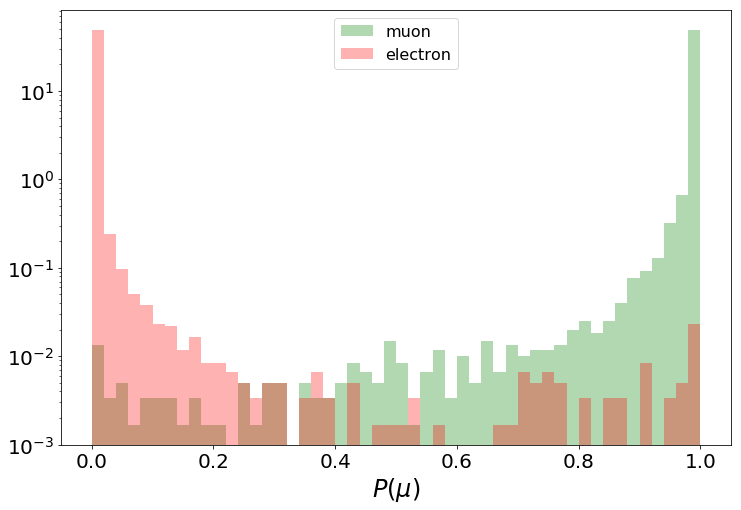

In [22]:
plot_resp(labels_val,softmax_out_val)

### The confusion matrix

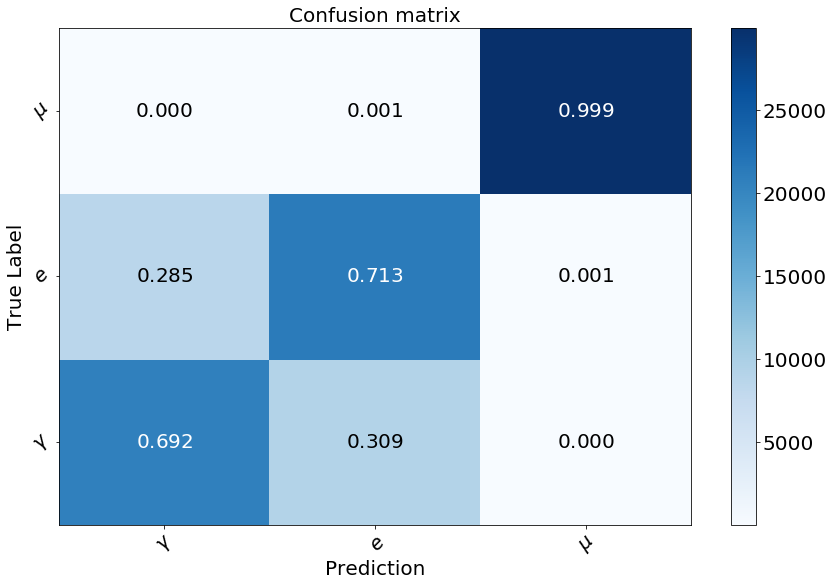

In [24]:
plot_utils.plot_confusion_matrix(labels_val, predictions_val, ['$\gamma$','$e$','$\mu$'])

### Receiver Operating Characteristic
   - We will plot ROC treating electrons as 'signal' and photons as 'background', but we have also muons - which is also a signal, so we have more reasonable possibilities of plotting ROC curves - can you name advantages and disadvantages?

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


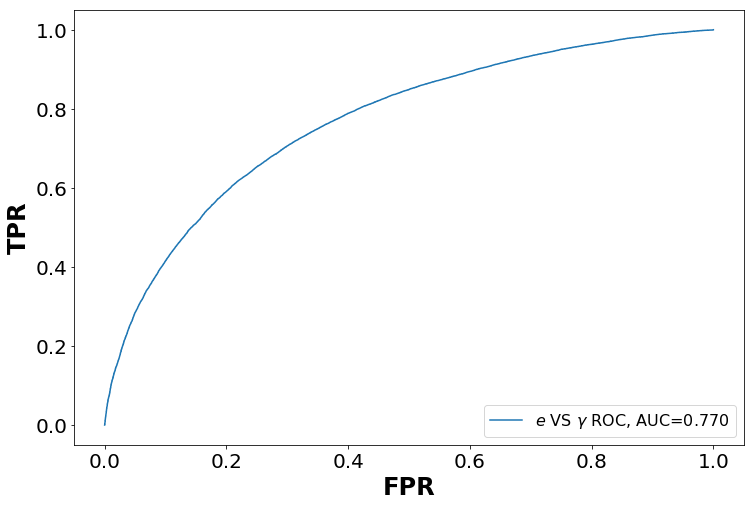

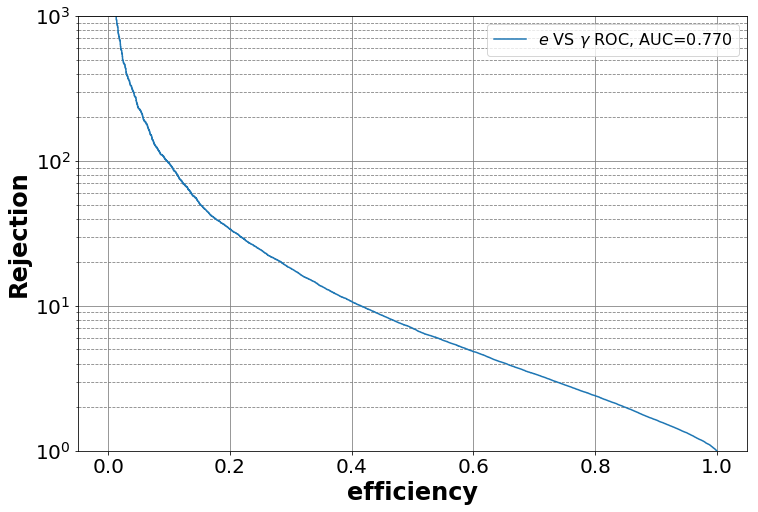

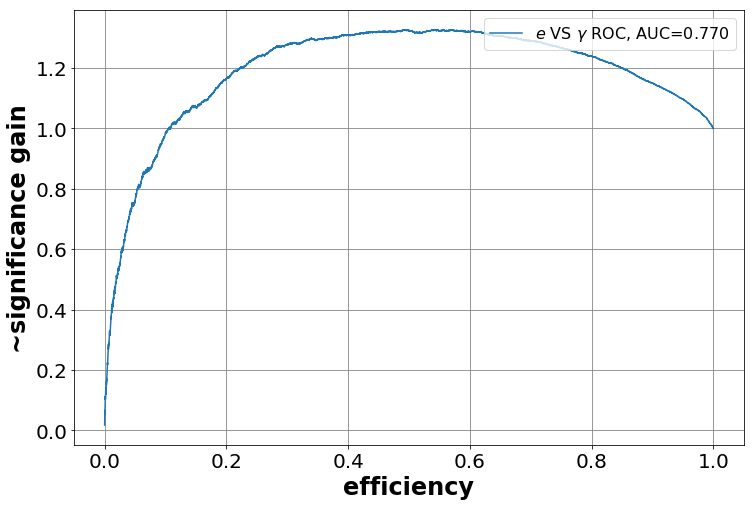

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
labels_val_e_gamma=labels_val[np.where( (labels_val==0) | (labels_val==1))]
softmax_out_val_e_gamma=softmax_out_val[np.where( (labels_val==0) | (labels_val==1))][:,1]
fpr,tpr,thr=roc_curve(labels_val_e_gamma,softmax_out_val_e_gamma)
roc_AUC=auc(fpr,tpr)
fig1, ax1 = plt.subplots(figsize=(12,8),facecolor="w")
ax1.tick_params(axis="both", labelsize=20)
ax1.plot(fpr,tpr,label=r'$e$ VS $\gamma$ ROC, AUC={:.3f}'.format(roc_AUC))
ax1.set_xlabel('FPR',fontweight='bold',fontsize=24,color='black')
ax1.set_ylabel('TPR',fontweight='bold',fontsize=24,color='black')
ax1.legend(loc="lower right",prop={'size': 16})

rejection=1.0/(fpr+1e-10)

fig2, ax2 = plt.subplots(figsize=(12,8),facecolor="w")
ax2.tick_params(axis="both", labelsize=20)
plt.yscale('log')
plt.ylim(1.0,1.0e3)
plt.grid(b=True, which='major', color='gray', linestyle='-')
plt.grid(b=True, which='minor', color='gray', linestyle='--')
ax2.plot(tpr, rejection, label=r'$e$ VS $\gamma$ ROC, AUC={:.3f}'.format(roc_AUC))
ax2.set_xlabel('efficiency',fontweight='bold',fontsize=24,color='black')
ax2.set_ylabel('Rejection',fontweight='bold',fontsize=24,color='black')
ax2.legend(loc="upper right",prop={'size': 16})

fig2, ax2 = plt.subplots(figsize=(12,8),facecolor="w")
ax2.tick_params(axis="both", labelsize=20)
#plt.yscale('log')
#plt.ylim(1.0,1)
plt.grid(b=True, which='major', color='gray', linestyle='-')
plt.grid(b=True, which='minor', color='gray', linestyle='--')
ax2.plot(tpr, tpr/np.sqrt(fpr), label=r'$e$ VS $\gamma$ ROC, AUC={:.3f}'.format(roc_AUC))
ax2.set_xlabel('efficiency',fontweight='bold',fontsize=24,color='black')
ax2.set_ylabel('~significance gain',fontweight='bold',fontsize=24,color='black')
ax2.legend(loc="upper right",prop={'size': 16})

plt.show()
